# Preprocessing

In [1]:
from google.colab import drive # run only if runnning in colab
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
import json
import numpy as np
import os

# Load cleaned CFPB data (local)
# df = pd.read_csv("../data/interim/cfpb_mortgage_2024_clean.csv")

# Loan cleaned CFPB data (Colab)
colab_dir = "/content/drive/MyDrive/NLP/respect-cfpb"
df = pd.read_csv(os.path.join(colab_dir, "data/interim/cfpb_mortgage_2024_clean.csv"))

# Verify expected columns
print(df.columns)

# Create binary risk flag
RISKY = {"Closed with monetary relief", "Closed with non-monetary relief"}
df["risk_flag"] = df["company_response"].isin(RISKY).astype(int)

# Drop rows with missing or empty narratives
df = df[df["clean_text"].notna() & (df["clean_text"].str.strip() != "")]

# Check class balance
print(df["risk_flag"].value_counts(normalize=True))
print(df["risk_flag"].value_counts())

# First split: train (60%) vs temp (40%)
train_df, temp_df = train_test_split(
    df,
    test_size=0.4,
    stratify=df["risk_flag"],
    random_state=42
)

# Second split: validation (20%) and test (20%) from temp
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    stratify=temp_df["risk_flag"],
    random_state=42
)

# Confirm split sizes and balance
print("Train:", len(train_df), "Val:", len(val_df), "Test:", len(test_df))
print("Train risk ratio:", train_df["risk_flag"].mean())
print("Val risk ratio:", val_df["risk_flag"].mean())
print("Test risk ratio:", test_df["risk_flag"].mean())

# Save splits to data/splits folder (local)
# os.makedirs("../data/processed", exist_ok=True)
# train_df.to_csv("../data/processed/train.csv", index=False)
# val_df.to_csv("../data/processed/val.csv", index=False)
# test_df.to_csv("../data/processed/test.csv", index=False)

# Save splits to data/splits folder (colab)
processed_dir = os.path.join(colab_dir, "data/processed")
os.makedirs(processed_dir, exist_ok=True)
train_df.to_csv(os.path.join(processed_dir, "train.csv"), index=False)
val_df.to_csv(os.path.join(processed_dir, "val.csv"), index=False)
test_df.to_csv(os.path.join(processed_dir, "test.csv"), index=False)

Index(['complaint_id', 'date_received', 'company', 'issue', 'sub_product',
       'clean_text', 'word_len', 'company_response', 'timely', 'state',
       'month'],
      dtype='object')
risk_flag
0    0.951168
1    0.048832
Name: proportion, dtype: float64
risk_flag
0    11239
1      577
Name: count, dtype: int64
Train: 7089 Val: 2363 Test: 2364
Train risk ratio: 0.048808012413598535
Val risk ratio: 0.048666948793906054
Test risk ratio: 0.049069373942470386


# Baseline Model: TF-IDF

In [ ]:
# Import required libraries
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, roc_auc_score, confusion_matrix,
    precision_recall_curve, auc
)
import matplotlib.pyplot as plt
import seaborn as sns

# Load pre-split data (local)
# train_df = pd.read_csv("../data/processed/train.csv")
# val_df = pd.read_csv("../data/processed/val.csv")
# test_df = pd.read_csv("../data/processed/test.csv")

# Load pre-split data (Colab)
train_df = pd.read_csv(os.path.join(colab_dir, "data/processed/train.csv"))
val_df = pd.read_csv(os.path.join(colab_dir, "data/processed/val.csv"))
test_df = pd.read_csv(os.path.join(colab_dir, "data/processed/test.csv"))

# Extract features and labels
X_train, y_train = train_df["clean_text"], train_df["risk_flag"]
X_val, y_val = val_df["clean_text"], val_df["risk_flag"]
X_test, y_test = test_df["clean_text"], test_df["risk_flag"]

# TF-IDF vectorization
vectorizer = TfidfVectorizer(
    max_features=50000,   # vocabulary cap for efficiency
    ngram_range=(1,1),     # unigrams and bigrams
    stop_words='english',
    min_df=5               # ignore rare tokens
)

X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)
X_test_tfidf = vectorizer.transform(X_test)

# Logistic Regression model with class weighting
model = LogisticRegression(
    class_weight="balanced",
    max_iter=1000,
    solver="liblinear",
    C=0.01,
    random_state=42
)

# Train the model
model.fit(X_train_tfidf, y_train)

# Evaluate generalization between training and validation
y_train_pred = model.predict(X_train_tfidf)
y_train_prob = model.predict_proba(X_train_tfidf)[:, 1]

y_val_pred = model.predict(X_val_tfidf)
y_val_prob = model.predict_proba(X_val_tfidf)[:, 1]

print("Training Results")
print(classification_report(y_train, y_train_pred, digits=3))
print("ROC-AUC:", roc_auc_score(y_train, y_train_prob))

print("\nValidation Results")
print(classification_report(y_val, y_val_pred, digits=3))
print("ROC-AUC:", roc_auc_score(y_val, y_val_prob))


Training Results
              precision    recall  f1-score   support

           0      0.987     0.828     0.901      6743
           1      0.190     0.786     0.306       346

    accuracy                          0.826      7089
   macro avg      0.588     0.807     0.603      7089
weighted avg      0.948     0.826     0.872      7089

ROC-AUC: 0.8902199154936097

Validation Results
              precision    recall  f1-score   support

           0      0.977     0.811     0.886      2248
           1      0.147     0.635     0.238       115

    accuracy                          0.802      2363
   macro avg      0.562     0.723     0.562      2363
weighted avg      0.937     0.802     0.855      2363

ROC-AUC: 0.8033614420547733


Test Results
              precision    recall  f1-score   support

           0      0.973     0.799     0.878      2248
           1      0.129     0.578     0.211       116

    accuracy                          0.788      2364
   macro avg      0.551     0.688     0.544      2364
weighted avg      0.932     0.788     0.845      2364

ROC-AUC: 0.7852228801079887


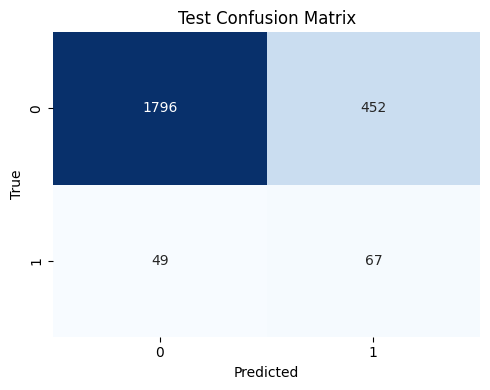

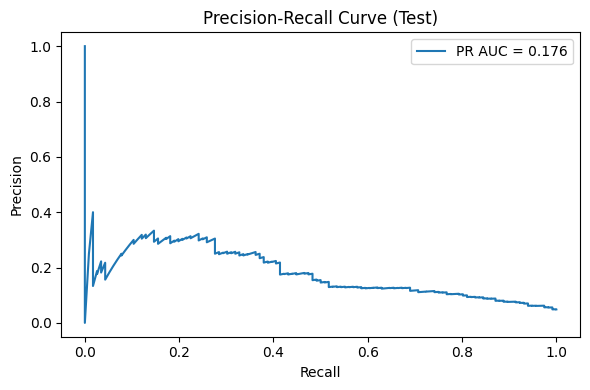

In [ ]:
# Predict on test set
test_preds = model.predict(X_test_tfidf)
test_probs = model.predict_proba(X_test_tfidf)[:, 1]

# Print performance report
print("Test Results")
print(classification_report(y_test, test_preds, digits=3))
print("ROC-AUC:", roc_auc_score(y_test, test_probs))

# Confusion matrix
cm_test = confusion_matrix(y_test, test_preds)
plt.figure(figsize=(5, 4))
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Test Confusion Matrix")
plt.tight_layout()
plt.show()

# Precision-Recall curve
prec, rec, _ = precision_recall_curve(y_test, test_probs)
pr_auc = auc(rec, prec)

plt.figure(figsize=(6, 4))
plt.plot(rec, prec, label=f"PR AUC = {pr_auc:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (Test)")
plt.legend()
plt.tight_layout()
plt.show()



In [ ]:
# Save results for later
baseline_results = {
    "model_name": "tfidf_logreg_baseline",
    "performance": {
        "test": {
            "roc_auc": float(roc_auc_score(y_test, test_probs)),
            "precision_risk": float(np.round(classification_report(y_test, test_preds, output_dict=True)['1']['precision'], 3)),
            "recall_risk": float(np.round(classification_report(y_test, test_preds, output_dict=True)['1']['recall'], 3)),
            "f1_risk": float(np.round(classification_report(y_test, test_preds, output_dict=True)['1']['f1-score'], 3)),
            "accuracy": float(np.round(classification_report(y_test, test_preds, output_dict=True)['accuracy'], 3))
        }
    }
}

# Create output folder
os.makedirs("../outputs/models", exist_ok=True)

# Save as JSON
output_path = "../outputs/models/baseline_tfidf_logreg_results.json"
with open(output_path, "w") as f:
    json.dump(baseline_results, f, indent=4)



---


# Improved Model: FinBERT & LoRA

## Load FinBERT

In [3]:
!pip install -q evaluate>=0.4.2

import os
import numpy as np
import pandas as pd
import torch

from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    set_seed,
)
from peft import LoraConfig, get_peft_model, TaskType
from torch.nn import CrossEntropyLoss
import evaluate

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

# Load pre-split training, validation, and test sets that contains clean_text and risk_flag (Colab)
colab_dir = "/content/drive/MyDrive/NLP/respect-cfpb"
train_df = pd.read_csv(os.path.join(colab_dir, "data/processed/train.csv"))
val_df = pd.read_csv(os.path.join(colab_dir, "data/processed/val.csv"))
test_df = pd.read_csv(os.path.join(colab_dir, "data/processed/test.csv"))

# Initiate and load tokenizer for FinBERT
model_name = "ProsusAI/finbert"
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)

# Convert DataFrames to Hugging Face Datasets; keep only the clean_text and risk_flag (target column)
train_dataset = Dataset.from_pandas(train_df[["clean_text", "risk_flag"]]).rename_column("risk_flag", "labels")
val_dataset   = Dataset.from_pandas(val_df[["clean_text", "risk_flag"]]).rename_column("risk_flag", "labels")
test_dataset  = Dataset.from_pandas(test_df[["clean_text", "risk_flag"]]).rename_column("risk_flag", "labels")

# Tokenize input text
def tokenize_function(examples):
    return tokenizer(
        examples["clean_text"],
        truncation=True,
        padding="max_length",
        max_length=512
    )

train_dataset = train_dataset.map(tokenize_function, batched=True, remove_columns=["clean_text"])
val_dataset   = val_dataset.map(tokenize_function, batched=True, remove_columns=["clean_text"])
test_dataset  = test_dataset.map(tokenize_function, batched=True, remove_columns=["clean_text"])

# Tell datasets to return PyTorch tensors
train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
val_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

device: cuda


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Map:   0%|          | 0/7089 [00:00<?, ? examples/s]

Map:   0%|          | 0/2363 [00:00<?, ? examples/s]

Map:   0%|          | 0/2364 [00:00<?, ? examples/s]

**Skip This Section for Rerun**

*This section kept for comparison only. New run uses balanced sampler below*

## Class balancing - weighted cross-entropy loss function
To address the class imbalance in our dataset, we apply a weighted cross-entropy loss function.
This technique rebalances the contribution of each class during training by assigning higher weights to the minority class (“risk”), which comprises only ~5% of the complaints.

Following the approach described in
* “Addressing Data Imbalance in Transformers” ([arXiv:2507.11384v1](https://arxiv.org/html/2507.11384v1)), and
* “Baseline with HuggingFace” ([Inagana, Kaggle, 2023](https://www.kaggle.com/code/inagana/baseline-with-huggingface-training-beginners)),

In [ ]:
# Compute class weights from train_df
counts = train_df["risk_flag"].value_counts()
n_total = len(train_df)

# inverse frequency weighting to give rare classes higher weights
weight_for_0 = n_total / counts[0]
weight_for_1 = n_total / counts[1] * 2 # scale up positive class

# convert to tensor and push to device
class_weights = torch.tensor([weight_for_0, weight_for_1], dtype=torch.float).to(device)
print("Class Weights:", class_weights)

# Define a weighted Trainer
class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        # Remove labels from dictionary to allow computatio of loss manually
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        # Apply custom weighted loss
        loss_fct = CrossEntropyLoss(weight=class_weights)
        loss = loss_fct(
            logits.view(-1, model.config.num_labels),
            labels.view(-1)
        )
        return (loss, outputs) if return_outputs else loss

Class Weights: tensor([ 1.0513, 40.9769], device='cuda:0')


## LoRA Fine-Tuning
Source: W266 Walkthrough Notebook for Lora

In [ ]:
# Load FinBERT model
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2, # Set number of labels to 2 (1=risk, 0=no risk)
    ignore_mismatched_sizes=True # since we are changing the num of labels
).to(device)

# LoRA configuration
lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=8,
    lora_alpha=32,
    lora_dropout=0.1,
    bias="none"
)
# Inject LoRA adapters into FinBERT
model = get_peft_model(model, lora_config)
model.print_trainable_parameters()


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ProsusAI/finbert and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 296,450 || all params: 109,780,228 || trainable%: 0.2700


In [ ]:
# Evaluation metrics
accuracy_metric = evaluate.load("accuracy")
precision_metric = evaluate.load("precision")
recall_metric = evaluate.load("recall")
f1_metric = evaluate.load("f1")

def compute_metrics(p):
    predictions, labels = p
    preds = np.argmax(predictions, axis=1)

    accuracy = accuracy_metric.compute(predictions=preds, references=labels)["accuracy"]
    precision = precision_metric.compute(predictions=preds, references=labels, average="binary")["precision"]
    recall = recall_metric.compute(predictions=preds, references=labels, average="binary")["recall"]
    f1 = f1_metric.compute(predictions=preds, references=labels, average="binary")["f1"]

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

In [ ]:
training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/NLP/respect-cfpb/models/finbert_lora_clean",
    learning_rate=1e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.05,
    lr_scheduler_type="linear",
    warmup_ratio=0.0,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    logging_steps=25,
    report_to="none",
    gradient_accumulation_steps=2,
    seed=42,
    metric_for_best_model="f1",
    greater_is_better=True
)

In [ ]:
# Train model
trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)
trainer.train()

/tmp/ipython-input-2650450409.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.580800,0.592036,0.949640,0.000000,0.000000,0.000000
2,0.635800,0.590164,0.950063,0.000000,0.000000,0.000000
3,0.576800,0.590022,0.950487,0.000000,0.000000,0.000000


TrainOutput(global_step=1332, training_loss=0.6194535107225985, metrics={'train_runtime': 375.8587, 'train_samples_per_second': 56.582, 'train_steps_per_second': 3.544, 'total_flos': 5614950552145920.0, 'train_loss': 0.6194535107225985, 'epoch': 3.0})

**Ues This Section for the Rerun**

## Balanced Sampling for Training in FinBERT
In earlier experiements, we attempted to address the severe class imbalance in our training data by using a custom weighted cross-entropy loss. This approach increases the loss contribution of the minority class so the model is penalized more heavily when it misclassifies class 1 (risk flag). Although intuitive, this method was not sufficient in our case. Across many training runs, the model continued to predict the majority class almost exclusively, indicating that the minority-class signal was still being overwhelmed during gradient updates. In other words, even when the model noticed minority examples, it did not see enough of them within each batch to meaningfully adjust its internal representations.

Because of this, we introduce a second technique: **balanced sampling**. Instead of modifying the loss function, balanced sampling modifies how batches are constructed. The key idea is that the model should see roughly the same number of positive and negative examples within each training batch, even if the underlying dataset is imbalanced.

To implement this, we use PyTorch WeightedRandomSampler, which assigns sampling weights to each training instance based on the inverse frequency of its class. As a result:
* Class 0 samples receive lower sampling probability
* Class 1 samples receive higher sampling probability
* Each batch contains a balanced mix of classes regardless of the dataset imbalance
* No data is duplicated or discarded (unlike oversampling or undersampling)

We used PyTorch's WeightedRandomSampler, which allows each batch to sample from classes in proportion of inverted class frequencies as described in:
* https://pytorch.org/docs/stable/data.html#torch.utils.data.WeightedRandomSampler
* https://medium.com/data-science/demystifying-pytorchs-weightedrandomsampler-by-example-a68aceccb452
* https://github.com/pytorch/pytorch/blob/main/torch/utils/data/sampler.py#L73-L90


In [5]:
import torch
from torch.utils.data import DataLoader, WeightedRandomSampler
from transformers import DataCollatorWithPadding, AutoModelForSequenceClassification, TrainingArguments, Trainer
from peft import LoraConfig, get_peft_model, TaskType
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report


**Build balanced weights**

In [11]:
# Count classes in the training dataset
train_labels = train_dataset["labels"]
class_counts = np.bincount(train_labels)
num_samples = len(train_labels)

print("Class counts in training set:", class_counts)

# Inverse-frequency weights for each class
weights = 1.0 / class_counts # inverse frequency results in higher probability for minority class
sample_weights = [weights[label] for label in train_labels] # assign per example weight based on label

# Sampler that draws samples according to these weights
sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=num_samples,   # same number of samples per epoch
    replacement=True           # sampling with replacement
)

Class counts in training set: [6743  346]


In [12]:
train_dataloader = DataLoader(
    train_dataset,
    batch_size=8,
    sampler=sampler #apply the balanced batch defined ealier
)

# Evaluation uses regular sequential loading
eval_dataloader = DataLoader(
    val_dataset,
    batch_size=8,
    shuffle=False
)

# custom Trainer that uses our sampler-based dataloaders
class BalancedTrainer(Trainer):
    def get_train_dataloader(self):
        return train_dataloader

    def get_eval_dataloader(self, eval_dataset=None):
        return eval_dataloader

# metrics using threshold 0.5 during training
def compute_metrics_balanced(eval_pred):
    logits, labels = eval_pred
    labels = np.array(labels)

    probs = torch.softmax(torch.tensor(logits), dim=1)[:, 1].numpy()
    preds = (probs >= 0.5).astype(int)

    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, zero_division=0)
    recall = recall_score(labels, preds, zero_division=0)
    f1 = f1_score(labels, preds, zero_division=0)

    try:
        roc_auc = roc_auc_score(labels, probs)
    except ValueError:
        roc_auc = float("nan")

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "roc_auc": roc_auc,
    }

In [13]:
def train_hp(config):
    lr = config["lr"]
    r = config["r"]
    num_epochs = config["epochs"]
    run_name = config["name"]

    print(f"\n=== Training run: {run_name} | lr={lr} | r={r} | epochs={num_epochs} ===")

    # fresh base model each time
    base_model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=2,
        ignore_mismatched_sizes=True
    )

    lora_cfg = LoraConfig(
        task_type=TaskType.SEQ_CLS,
        r=r,
        lora_alpha=2*r,
        lora_dropout=0.1,
        bias="none"
    )
    model_lora = get_peft_model(base_model, lora_cfg).to(device)

    training_args = TrainingArguments(
        output_dir=os.path.join(
            colab_dir, f"models/finbert_lora_balanced_{run_name}"
        ),
        learning_rate=lr,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        num_train_epochs=num_epochs,
        weight_decay=0.01,
        warmup_ratio=0.05,
        lr_scheduler_type="linear",
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        greater_is_better=True,
        logging_steps=50,
        gradient_accumulation_steps=2,
        seed=42,
        report_to="none",
    )

    trainer = BalancedTrainer(
        model=model_lora,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics_balanced,
    )

    trainer.train()
    metrics = trainer.evaluate()
    print(f"Final val metrics for {run_name}:")
    print(metrics)

    # keep track of what worked
    return {
        "name": run_name,
        "lr": lr,
        "r": r,
        "epochs": num_epochs,
        "metrics": metrics,
        "trainer": trainer,   # so you can later reuse the best
    }

In [14]:
configs = [
    {"name": "r4_lr1e-5",  "r": 4, "lr": 1e-5, "epochs": 3},
    {"name": "r8_lr1e-5",  "r": 8, "lr": 1e-5, "epochs": 3},
    {"name": "r4_lr5e-6",  "r": 4, "lr": 5e-6, "epochs": 3},
    {"name": "r8_lr5e-6",  "r": 8, "lr": 5e-6, "epochs": 3},
]

In [15]:
all_runs = []
for cfg in configs:
    result = train_hp(cfg)
    all_runs.append(result)

for r in all_runs:
    m = r["metrics"]
    print(
        r["name"],
        "| f1:", round(m["eval_f1"], 3),
        "| recall:", round(m["eval_recall"], 3),
        "| precision:", round(m["eval_precision"], 3),
        "| roc_auc:", round(m["eval_roc_auc"], 3),
    )


=== Training run: r4_lr1e-5 | lr=1e-05 | r=4 | epochs=3 ===


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ProsusAI/finbert and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-113546508.py:47: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `BalancedTrainer.__init__`. Use `processing_class` instead.
  trainer = BalancedTrainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Roc Auc
1,0.691100,0.700530,0.471858,0.044248,0.478261,0.081001,0.475994
2,0.686100,0.687095,0.548455,0.044061,0.400000,0.079379,0.479843
3,0.691600,0.699763,0.479475,0.045640,0.486957,0.083458,0.481127


Final val metrics for r4_lr1e-5:
{'eval_loss': 0.6997628808021545, 'eval_accuracy': 0.47947524333474395, 'eval_precision': 0.045639771801140996, 'eval_recall': 0.48695652173913045, 'eval_f1': 0.08345752608047691, 'eval_roc_auc': 0.48112718551756145, 'eval_runtime': 15.6223, 'eval_samples_per_second': 151.258, 'eval_steps_per_second': 18.947, 'epoch': 3.0}

=== Training run: r8_lr1e-5 | lr=1e-05 | r=8 | epochs=3 ===


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ProsusAI/finbert and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-113546508.py:47: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `BalancedTrainer.__init__`. Use `processing_class` instead.
  trainer = BalancedTrainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Roc Auc
1,0.693100,0.744668,0.178587,0.048913,0.860870,0.092567,0.501644
2,0.689100,0.715397,0.393144,0.047978,0.608696,0.088945,0.492453
3,0.685800,0.724975,0.336860,0.047945,0.669565,0.089483,0.495907


Final val metrics for r8_lr1e-5:
{'eval_loss': 0.7446680665016174, 'eval_accuracy': 0.17858654253068135, 'eval_precision': 0.04891304347826087, 'eval_recall': 0.8608695652173913, 'eval_f1': 0.09256661991584852, 'eval_roc_auc': 0.501643973386972, 'eval_runtime': 15.5794, 'eval_samples_per_second': 151.675, 'eval_steps_per_second': 18.999, 'epoch': 3.0}

=== Training run: r4_lr5e-6 | lr=5e-06 | r=4 | epochs=3 ===


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ProsusAI/finbert and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-113546508.py:47: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `BalancedTrainer.__init__`. Use `processing_class` instead.
  trainer = BalancedTrainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Roc Auc
1,0.704600,0.844627,0.053322,0.048895,1.000000,0.093231,0.534019
2,0.693000,0.738783,0.189166,0.050424,0.878261,0.095373,0.515043
3,0.689400,0.736287,0.206517,0.049642,0.843478,0.093765,0.511852


Final val metrics for r4_lr5e-6:
{'eval_loss': 0.7387833595275879, 'eval_accuracy': 0.18916631400761744, 'eval_precision': 0.050424363454817774, 'eval_recall': 0.8782608695652174, 'eval_f1': 0.09537299338999056, 'eval_roc_auc': 0.5150433235339625, 'eval_runtime': 15.626, 'eval_samples_per_second': 151.223, 'eval_steps_per_second': 18.943, 'epoch': 3.0}

=== Training run: r8_lr5e-6 | lr=5e-06 | r=8 | epochs=3 ===


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ProsusAI/finbert and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-113546508.py:47: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `BalancedTrainer.__init__`. Use `processing_class` instead.
  trainer = BalancedTrainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Roc Auc
1,0.703100,0.836990,0.060516,0.048864,0.991304,0.093137,0.523948
2,0.692700,0.739903,0.172662,0.048134,0.852174,0.091120,0.511183
3,0.688500,0.737879,0.188743,0.048597,0.843478,0.091900,0.509570


Final val metrics for r8_lr5e-6:
{'eval_loss': 0.8369901776313782, 'eval_accuracy': 0.060516292848074485, 'eval_precision': 0.0488641234462066, 'eval_recall': 0.991304347826087, 'eval_f1': 0.09313725490196079, 'eval_roc_auc': 0.5239478570323379, 'eval_runtime': 15.5931, 'eval_samples_per_second': 151.541, 'eval_steps_per_second': 18.983, 'epoch': 3.0}
r4_lr1e-5 | f1: 0.083 | recall: 0.487 | precision: 0.046 | roc_auc: 0.481
r8_lr1e-5 | f1: 0.093 | recall: 0.861 | precision: 0.049 | roc_auc: 0.502
r4_lr5e-6 | f1: 0.095 | recall: 0.878 | precision: 0.05 | roc_auc: 0.515
r8_lr5e-6 | f1: 0.093 | recall: 0.991 | precision: 0.049 | roc_auc: 0.524


# Full FinBERT Fine Tuning

### Why LoRA Did Not Work Reliably

So far, we tried to fine tune FinBERT using LoRA together with:

- Custom class weighted loss  
- Balanced sampling with `WeightedRandomSampler`  
- Several different hyperparameter settings

Across many runs we kept seeing the same pattern:

- The model often predicted almost everything as class 0  
- When we pushed too hard on imbalance, it flipped and predicted too many class 1s  

This suggests that the LoRA setup plus our imbalance handling created a model that was fragile and hard to tune in a stable way.

**Possible reasons:**

- **Strong class imbalance**  
  Only about 5 percent of complaints are labeled as risky (class 1). A model can achieve high accuracy by defaulting to class 0, and it needs a strong and consistent signal to learn class 1.

- **Risky and non risky complaints are linguistically similar**  
  Many narratives look similar on the surface. The difference between risky and non risky often depends on subtle details about the outcome, harm, or regulatory context. This makes the decision boundary harder to learn.

- **Extra LoRA hyperparameters make things more sensitive**  
  LoRA introduces extra knobs such as rank `r`, `lora_alpha`, and dropout. Those hyperparameters interact with class imbalance and loss weighting. Small changes can lead to very different behavior, which we observed in practice.

- **Balancing tricks can destabilize training**  
  We tried loss weighting, oversampling, and balanced sampling. All three are designed to push the model to pay more attention to class 1. In combination they can make training unstable and can cause the model to oscillate between predicting almost all zeros and predicting too many ones.

Overall, the LoRA approach became complex and difficult to control. The fact that a single good run was not reproducible is a sign that the method is not robust in this setting.

---

### New Plan: Full FinBERT Fine Tuning

To simplify and stabilize the approach, we now switch to full FinBERT fine tuning:

- We keep the same train, validation, and test splits so results are comparable.
- We start with one imbalance strategy at a time, instead of stacking several together. For example:
  - Class weighted cross entropy loss  
  - No oversampling and no custom sampler in the first iteration

**Why this makes sense:**

- The architecture is simpler. There are no LoRA adapters and fewer moving parts, which makes debugging easier.
- The model has more capacity to adjust to the subtle differences between risky and non risky complaints because all layers can update.


In the next cells we will:

1. Load full FinBERT with a two class classification head.  
2. Define a simple class weighted loss via a custom `Trainer` subclass.  
3. Train on the original training set and evaluate on the validation set.  
4. Once results look stable, evaluate on the held out test set and compare to the baseline model.

In [2]:
import os
import numpy as np
import pandas as pd
import torch

from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Project root in Drive
colab_dir = "/content/drive/MyDrive/NLP/respect-cfpb"

# Load pre-split data
train_df = pd.read_csv(os.path.join(colab_dir, "data/processed/train.csv"))
val_df   = pd.read_csv(os.path.join(colab_dir, "data/processed/val.csv"))
test_df  = pd.read_csv(os.path.join(colab_dir, "data/processed/test.csv"))

print("Train shape:", train_df.shape)
print("Val shape  :", val_df.shape)
print("Test shape :", test_df.shape)
print("Train label counts:\n", train_df["risk_flag"].value_counts())

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# FinBERT model name
model_name = "ProsusAI/finbert"

# Tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)

Train shape: (7089, 12)
Val shape  : (2363, 12)
Test shape : (2364, 12)
Train label counts:
 risk_flag
0    6743
1     346
Name: count, dtype: int64
Device: cuda


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [3]:
from datasets import Dataset

# Convert to Dataset and rename label column to "labels"
train_dataset = Dataset.from_pandas(
    train_df[["clean_text", "risk_flag"]]
).rename_column("risk_flag", "labels")

val_dataset = Dataset.from_pandas(
    val_df[["clean_text", "risk_flag"]]
).rename_column("risk_flag", "labels")

test_dataset = Dataset.from_pandas(
    test_df[["clean_text", "risk_flag"]]
).rename_column("risk_flag", "labels")

def tokenize_function(examples):
    return tokenizer(
        examples["clean_text"],
        truncation=True,
        padding="max_length",
        max_length=512,
    )

train_dataset = train_dataset.map(
    tokenize_function,
    batched=True,
    remove_columns=["clean_text"]
)

val_dataset = val_dataset.map(
    tokenize_function,
    batched=True,
    remove_columns=["clean_text"]
)

test_dataset = test_dataset.map(
    tokenize_function,
    batched=True,
    remove_columns=["clean_text"]
)

# Tell datasets to return PyTorch tensors
train_dataset.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "labels"]
)
val_dataset.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "labels"]
)
test_dataset.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "labels"]
)

print(train_dataset)
print(val_dataset)
print(test_dataset)

Map:   0%|          | 0/7089 [00:00<?, ? examples/s]

Map:   0%|          | 0/2363 [00:00<?, ? examples/s]

Map:   0%|          | 0/2364 [00:00<?, ? examples/s]

Dataset({
    features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 7089
})
Dataset({
    features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 2363
})
Dataset({
    features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 2364
})


In [49]:
from transformers import Trainer
from torch.nn import CrossEntropyLoss

# Compute class weights from *original* training labels
train_labels = train_df["risk_flag"].values
class_counts = np.bincount(train_labels)
print("Class counts:", class_counts)

n_total = len(train_labels)
weight_for_0 = n_total / class_counts[0]
weight_for_1 = n_total / class_counts[1]

class_weights = torch.tensor(
    [weight_for_0, weight_for_1],
    dtype=torch.float32,
    device=device
)
print("Class weights tensor:", class_weights)

class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        """
        Custom loss: standard cross entropy, but with per-class weights.
        """
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits

        loss_fct = CrossEntropyLoss(weight=class_weights)
        loss = loss_fct(
            logits.view(-1, model.config.num_labels),
            labels.view(-1)
        )

        if return_outputs:
            return loss, outputs
        else:
            return loss

Class counts: [6743  346]
Class weights tensor: tensor([ 1.0513, 20.4884], device='cuda:0')


In [56]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2,                # {0: non-risk, 1: risk}
    ignore_mismatched_sizes=True # replace FinBERT's 3-class head
)
model.to(device)

print("Model loaded on:", device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ProsusAI/finbert and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded on: cuda


In [57]:
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    roc_auc_score
)
import numpy as np

def compute_metrics(eval_pred):
    logits, labels = eval_pred

    # Convert logits to probabilities for class 1
    probs = torch.softmax(torch.tensor(logits), dim=1)[:, 1].numpy()

    # use 0.5 threshold
    preds = (probs >= 0.5).astype(int)

    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, zero_division=0)
    recall = recall_score(labels, preds, zero_division=0)
    f1 = f1_score(labels, preds, zero_division=0)

    # ROC-AUC based on probabilities
    try:
        roc_auc = roc_auc_score(labels, probs)
    except ValueError:
        roc_auc = float("nan")

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "roc_auc": roc_auc,
    }

In [58]:
from transformers import TrainingArguments

output_dir = os.path.join(
    colab_dir,
    "models/finbert_full"
)

training_args = TrainingArguments(
    output_dir=output_dir,
    learning_rate=1e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=4,
    weight_decay=0.01,
    warmup_ratio=0.05,
    lr_scheduler_type="linear",
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="roc_auc",
    greater_is_better=True,
    logging_steps=50,
    gradient_accumulation_steps=2,
    seed=42,
    report_to="none",
)

trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

trainer

/tmp/ipython-input-2136468275.py:28: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


In [59]:
train_result = trainer.train()
train_result

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Roc Auc
1,0.537000,0.582137,0.951333,0.000000,0.000000,0.000000,0.623793
2,0.641800,0.497775,0.951333,0.000000,0.000000,0.000000,0.738446
3,0.577900,0.638445,0.943716,0.354839,0.191304,0.248588,0.769998
4,0.448900,0.725991,0.944139,0.365079,0.200000,0.258427,0.756951


TrainOutput(global_step=1776, training_loss=0.5669436486991676, metrics={'train_runtime': 654.3452, 'train_samples_per_second': 43.335, 'train_steps_per_second': 2.714, 'total_flos': 7460777085788160.0, 'train_loss': 0.5669436486991676, 'epoch': 4.0})

In [60]:
import numpy as np
import torch
from sklearn.metrics import classification_report, roc_auc_score, f1_score, precision_recall_fscore_support

# Get raw predictions on validation set
val_pred = trainer.predict(val_dataset)
val_logits = val_pred.predictions
val_labels = val_pred.label_ids

# Argmax predictions
val_argmax = np.argmax(val_logits, axis=1)

print("\nClassification report (argmax on val):")
print(classification_report(val_labels, val_argmax, digits=3))


Classification report (argmax on val):
              precision    recall  f1-score   support

           0      0.960     0.982     0.971      2248
           1      0.355     0.191     0.249       115

    accuracy                          0.944      2363
   macro avg      0.657     0.587     0.610      2363
weighted avg      0.930     0.944     0.936      2363



In [61]:
# Convert logits to probability for class 1
val_probs = torch.softmax(torch.tensor(val_logits), dim=1)[:, 1].numpy()

print("Mean prob(class=1) on val:", val_probs.mean())
print("Min prob(class=1):", val_probs.min())
print("Max prob(class=1):", val_probs.max())

def eval_threshold(y_true, y_prob, thr):
    preds = (y_prob >= thr).astype(int)
    p, r, f1, _ = precision_recall_fscore_support(
        y_true, preds, average="binary", zero_division=0
    )
    return p, r, f1

thresholds = np.linspace(0.01, 0.50, 20)

best_thr = None
best_f1 = -1
print("t\tF1_1\tP_1\tR_1")
for t in thresholds:
    p, r, f1 = eval_threshold(val_labels, val_probs, t)
    print(f"{t:0.3f}\t{f1:0.3f}\t{p:0.3f}\t{r:0.3f}")
    if f1 > best_f1:
        best_f1 = f1
        best_thr = t

try:
    val_roc = roc_auc_score(val_labels, val_probs)
except ValueError:
    val_roc = float("nan")

print("\nBest threshold on val:", best_thr, "Best F1_1:", best_f1)
print("Val ROC-AUC:", round(val_roc, 3))

Mean prob(class=1) on val: 0.06309678
Min prob(class=1): 0.0054615275
Max prob(class=1): 0.76740986
t	F1_1	P_1	R_1
0.010	0.119	0.064	0.948
0.036	0.195	0.116	0.635
0.062	0.230	0.144	0.574
0.087	0.229	0.151	0.478
0.113	0.248	0.169	0.461
0.139	0.249	0.177	0.417
0.165	0.255	0.189	0.391
0.191	0.260	0.197	0.383
0.216	0.276	0.216	0.383
0.242	0.270	0.217	0.357
0.268	0.278	0.231	0.348
0.294	0.290	0.253	0.339
0.319	0.293	0.264	0.330
0.345	0.303	0.287	0.322
0.371	0.304	0.304	0.304
0.397	0.314	0.324	0.304
0.423	0.315	0.337	0.296
0.448	0.317	0.355	0.287
0.474	0.281	0.351	0.235
0.500	0.249	0.355	0.191

Best threshold on val: 0.44842105263157894 Best F1_1: 0.3173076923076923
Val ROC-AUC: 0.77


In [62]:
# save the model
save_path = "/content/drive/MyDrive/NLP/respect-cfpb/models/finbert_full_ep4"

trainer.save_model(save_path)
tokenizer.save_pretrained(save_path)

print("Model saved to:", save_path)

Model saved to: /content/drive/MyDrive/NLP/respect-cfpb/models/finbert_full_ep4


In [64]:
print(trainer.state.best_model_checkpoint)

/content/drive/MyDrive/NLP/respect-cfpb/models/finbert_full/checkpoint-1332


# Evaluate with test set

In [4]:
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

best_ckpt = "/content/drive/MyDrive/NLP/respect-cfpb/models/finbert_full/checkpoint-1332"

# Load best model and tokenizer
test_model = AutoModelForSequenceClassification.from_pretrained(best_ckpt)
test_model.to(device)
test_model.eval()

test_tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert", use_fast=True)

Device: cuda


In [5]:
from torch.utils.data import DataLoader
import numpy as np
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, auc as sk_auc

# Use the test_dataset you already built
test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False
)

all_probs = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        # batch is a dict with input_ids, attention_mask, labels
        labels = batch["labels"].numpy()
        all_labels.extend(labels)

        # Move inputs to device
        inputs = {k: v.to(device) for k, v in batch.items() if k != "labels"}

        outputs = test_model(**inputs)
        logits = outputs.logits
        probs = torch.softmax(logits, dim=1)[:, 1]  # probability of risk_flag = 1
        all_probs.extend(probs.cpu().numpy())

all_probs = np.array(all_probs)
all_labels = np.array(all_labels)

print("Mean prob(class=1) on test:", all_probs.mean())
print("Min prob:", all_probs.min())
print("Max prob:", all_probs.max())

Mean prob(class=1) on test: 0.06734595
Min prob: 0.005443476
Max prob: 0.7467611


In [6]:
# Threshold chosen from validation sweep
threshold = 0.448

test_preds = (all_probs >= threshold).astype(int)

print(f"\nUsing threshold = {threshold}")
print(classification_report(all_labels, test_preds, digits=3))

test_roc_auc = roc_auc_score(all_labels, all_probs)
print("Test ROC-AUC:", round(test_roc_auc, 3))


Using threshold = 0.448
              precision    recall  f1-score   support

           0      0.960     0.968     0.964      2248
           1      0.263     0.224     0.242       116

    accuracy                          0.931      2364
   macro avg      0.611     0.596     0.603      2364
weighted avg      0.926     0.931     0.928      2364

Test ROC-AUC: 0.777



Confusion Matrix (Counts):
[[2175   73]
 [  90   26]]


<Figure size 500x500 with 0 Axes>

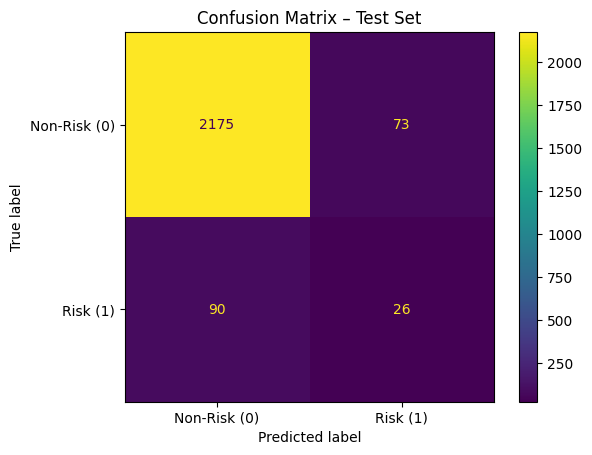


Confusion Matrix (Normalized):
[[0.96752669 0.03247331]
 [0.77586207 0.22413793]]


In [7]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
# Confusion Matrix
cm = confusion_matrix(all_labels, test_preds)

print("\nConfusion Matrix (Counts):")
print(cm)

# Plot the matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-Risk (0)", "Risk (1)"])
plt.figure(figsize=(5,5))
disp.plot(values_format='d')
plt.title("Confusion Matrix – Test Set")
plt.show()

# Normalized version
cm_norm = confusion_matrix(all_labels, test_preds, normalize='true')
print("\nConfusion Matrix (Normalized):")
print(cm_norm)

In [20]:
import os, json
from sklearn.metrics import classification_report, roc_auc_score

# Build results dictionary
finbert_results = {
    "model_name": "finbert_full_finetuned",
    "threshold": float(best_threshold),
    "performance": {
        "test": {
            "roc_auc": float(np.round(roc_auc_score(all_labels, all_probs), 3)),
            "precision_risk": float(np.round(classification_report(all_labels, preds_test, output_dict=True)['1']['precision'], 3)),
            "recall_risk": float(np.round(classification_report(all_labels, preds_test, output_dict=True)['1']['recall'], 3)),
            "f1_risk": float(np.round(classification_report(all_labels, preds_test, output_dict=True)['1']['f1-score'], 3)),
            "accuracy": float(np.round(classification_report(all_labels, preds_test, output_dict=True)['accuracy'], 3)),
            "support_risk": int(classification_report(all_labels, preds_test, output_dict=True)['1']['support']),
        }
    }
}

# Save JSON
output_path = "/content/drive/MyDrive/NLP/respect-cfpb/outputs/models/finbert_full_results.json"
with open(output_path, "w") as f:
    json.dump(finbert_results, f, indent=4)

print("Saved:", output_path)
finbert_results

Saved: /content/drive/MyDrive/NLP/respect-cfpb/outputs/models/finbert_full_results.json


{'model_name': 'finbert_full_finetuned',
 'threshold': 0.448,
 'performance': {'test': {'roc_auc': 0.777,
   'precision_risk': 0.252,
   'recall_risk': 0.224,
   'f1_risk': 0.237,
   'accuracy': 0.929,
   'support_risk': 116}}}

# Model Analysis

### Threshold sweep on test set
The sweep generates:
* F1-score for class 1
* Precision and recall at each threshold
* PR-AUC and ROC-AUC on the test set
* A clear understanding of how sensitive the model is to threshold shifts

At the test-set best F1 threshold (0.25):
* F1 = 0.275
* Recall = 0.379
* Precision = 0.216
* ROC-AUC = 0.777
* PR-AUC = 0.184

These numbers confirm the model is learning a real signal despite the challenging imbalance.

In [69]:
import numpy as np
import torch
from sklearn.metrics import (
    classification_report,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    precision_recall_curve,
    auc as sk_auc,
)

# Get raw model outputs on the test set
test_preds = trainer.predict(test_dataset)
logits = torch.tensor(test_preds.predictions)
probs_test = torch.softmax(logits, dim=1)[:, 1].numpy()  # P(risk_flag = 1)
y_test = np.array(test_preds.label_ids)

print(f"Mean prob(class=1) on test: {probs_test.mean():.4f}")
print(f"Min prob(class=1): {probs_test.min():.4f}")
print(f"Max prob(class=1): {probs_test.max():.4f}")

# Define thresholds to evaluate
thresholds = np.linspace(0.05, 0.9, 18)  # 0.05, 0.10, ..., 0.90

results = []
best_f1_1 = -1
best_t = None

print("t\tF1_1\tP_1\tR_1")
for t in thresholds:
    preds = (probs_test >= t).astype(int)

    p1 = precision_score(y_test, preds, pos_label=1, zero_division=0)
    r1 = recall_score(y_test, preds, pos_label=1, zero_division=0)
    f1_1 = f1_score(y_test, preds, pos_label=1, zero_division=0)

    results.append((t, f1_1, p1, r1))
    print(f"{t:.3f}\t{f1_1:.3f}\t{p1:.3f}\t{r1:.3f}")

    if f1_1 > best_f1_1:
        best_f1_1 = f1_1
        best_t = t

# Global metrics
roc_auc = roc_auc_score(y_test, probs_test)
prec_curve, rec_curve, _ = precision_recall_curve(y_test, probs_test)
pr_auc = sk_auc(rec_curve, prec_curve)

print("\nBest threshold on test:", best_t, "Best F1_1:", best_f1_1)
print("Test ROC-AUC:", round(roc_auc, 3))
print("Test PR-AUC:", round(pr_auc, 3))

# Detailed report at best threshold
best_preds = (probs_test >= best_t).astype(int)
print("\nClassification report at best threshold:")
print(classification_report(y_test, best_preds, digits=3))

Mean prob(class=1) on test: 0.0673
Min prob(class=1): 0.0054
Max prob(class=1): 0.7468
t	F1_1	P_1	R_1
0.050	0.224	0.137	0.612
0.100	0.260	0.171	0.543
0.150	0.260	0.182	0.457
0.200	0.261	0.194	0.397
0.250	0.275	0.216	0.379
0.300	0.270	0.225	0.336
0.350	0.267	0.240	0.302
0.400	0.261	0.254	0.267
0.450	0.244	0.268	0.224
0.500	0.211	0.270	0.172
0.550	0.185	0.281	0.138
0.600	0.143	0.289	0.095
0.650	0.058	0.190	0.034
0.700	0.033	0.286	0.017
0.750	0.000	0.000	0.000
0.800	0.000	0.000	0.000
0.850	0.000	0.000	0.000
0.900	0.000	0.000	0.000

Best threshold on test: 0.25 Best F1_1: 0.275
Test ROC-AUC: 0.777
Test PR-AUC: 0.184

Classification report at best threshold:
              precision    recall  f1-score   support

           0      0.967     0.929     0.947      2248
           1      0.216     0.379     0.275       116

    accuracy                          0.902      2364
   macro avg      0.591     0.654     0.611      2364
weighted avg      0.930     0.902     0.914      2364



In [11]:
# tuned threshold from validation set sweep
best_threshold = 0.448

# Get predicted probabilities using the model
test_model.eval()
test_texts = test_df["clean_text"].tolist()

probs_test = []
with torch.no_grad():
    for i in range(0, len(test_texts), 32):
        batch = test_texts[i:i+32] #batch 32 at a time
        # tokenize batch
        enc = tokenizer(batch, truncation=True, padding=True, max_length=256, return_tensors="pt")
        enc = {k: v.to(device) for k, v in enc.items()}
        # compute logits and apply softmax
        logits = test_model(**enc).logits
        p = torch.softmax(logits, dim=1)[:, 1]
        probs_test.extend(p.cpu().numpy())

probs_test = np.array(probs_test)
#convert probabilities to predicted class
preds_test = (probs_test >= best_threshold).astype(int)

# attach probabilities and predictions to the df
test_df["prob"] = probs_test
test_df["pred"] = preds_test

# True label
y_true = test_df["risk_flag"]

# Identify FS and FN
false_positives = test_df[(test_df["pred"] == 1) & (y_true == 0)]
false_negatives = test_df[(test_df["pred"] == 0) & (y_true == 1)]

false_positives.shape, false_negatives.shape







((77, 14), (90, 14))

### Analysis of Top False Positives (FPs)

A review of the highest-probability false positives shows a clear pattern:  
these complaints **look legitimately serious**, even though they are labeled as non-risk.

The model is not failing randomly. It is responding to strong textual signals that indicate real compliance risk.

-  Many FP complaints involve repeated servicing failures, incorrect fees, lost paperwork, foreclosure threats, or major financial harm.  
  These patterns closely resemble true risk cases.

- Terms like *misconduct*, *negligence*, *violation*, *illegal*, *compensation*, and repeated references to *CFPB* or *FHA guidelines* strongly push the model toward a risk prediction.

- Some cases involve genuine hardship, but the institution’s response was technically correct under policy, creating text that “sounds risky” even when labeled non-risk.

The model has learned a *broader textual signature of risk* than the strict SME definition used in labeling.  
High-probability FPs often contain real distress signals, which explains why the model elevates them even when the ground truth label is 0.

In [81]:
fp_top = false_positives.sort_values("prob", ascending=False).head(10)
print("Top FP: \n")
fp_top[["clean_text", "prob"]]

Top FP: 



,clean_text,prob
1436,i am writing to file a second formal complaint...,0.757488
486,as a result of a that did not involve our home...,0.728943
2025,i received a letter from the bank telling me t...,0.709417
1793,i am submitting this complaint due to ongoing ...,0.708257
706,i was working with a loan officer from bank of...,0.706659
440,in my home was flooded due to burst pipes impa...,0.706141
1455,i ve my mortgage loan with the fifth third ban...,0.703671
259,in may i paid a fee up front to have escrow se...,0.698233
437,on i called bank of america to apply for a hom...,0.667456
1875,i held a mortgage with us bank for years in go...,0.667078


### Analysis of Top False Negatives (FNs)

The model appears conservative when assigning the risk label. Many FN complaints describe situations that are regulatory violations or high-impact servicing failures, but they are written in a calm, factual, or procedural tone. Because of this, the model tends to overlook them.

Two key failure patterns emerge:

- Many FN cases involve forced-placed insurance, escrow misapplication, missing documentation, loan assumption errors, or improper delinquency reporting.  
These may feel like “administrative mishaps” to the consumer—but regulations often prohibit these practices, and they are legitimate high-risk servicing errors.  
The model misses these because they lack dramatic language or explicit emotional harm.

- When complaints are phrased calmly or without strong accusatory wording, the model underestimates risk even if the underlying facts represent violations (e.g., RESPA, FCRA, loss-mitigation rules).

Overall, the model misclassifies cases where the harm is real and regulatory in nature but the narrative is mild, causing risk to be underestimated despite clear servicing failures.

In [13]:
fn_top = false_negatives.sort_values("prob", ascending=True).head(10)
print("Top FN: \n")
fn_top[["clean_text", "prob"]]

Top FN: 



,clean_text,prob
1775,discover home loans wrote me several letters s...,0.006255
1398,on i made a payment to rocket mortgage over th...,0.006691
1315,it all started when i changed insurance compan...,0.007436
1221,i will upload a prepared letter and documentat...,0.007530
1785,i called pennymac with concerns about my upcom...,0.008591
1952,i wanted to provide you with some feedback on ...,0.008791
959,my loan was sold from my loan originator to in...,0.009190
157,dear sir madam i am writing to formally lodge ...,0.009273
1809,scrub i was contacted by phone by amerisave in...,0.009389
2145,midland mortgage is holding my loss draft mone...,0.009797


### Uncertainty Analysis (Distance From 0.5)

The table highlights complaints with predicted probabilities closest to 0.5, meaning the model is most unsure about these cases. These typically involve long, complex, and procedural disputes. For example, miscommunication, escrow errors, document handling issues, or administrative mishaps. In such scenarios, the distinction between poor customer service and actual compliance or regulatory risk is subtle, even for human reviewers.

The fact that the model expresses the highest uncertainty on these borderline cases suggests that it is appropriately calibrated:  
- High confidence on clearly compliant or clearly risky cases  
- Low confidence on cases where even humans would debate the classification

In [15]:

test_df["uncertainty"] = np.abs(test_df["prob"] - 0.5)
hard_cases = test_df.sort_values("uncertainty").head(10)
hard_cases[["clean_text", "prob", "uncertainty", "risk_flag"]]

,clean_text,prob,uncertainty,risk_flag
1735,my wife and i took out a residential construct...,0.499903,0.000097,0
182,in late year i dropped a check in a blue publi...,0.498770,0.001230,0
20,i am writing to file a formal complaint agains...,0.498740,0.001260,0
460,i did not originally initiate my mortgage with...,0.497497,0.002503,1
2230,in my realtor contacted me to share that i was...,0.497160,0.002840,0
822,i am writing to express my deep dissatisfactio...,0.495077,0.004923,0
593,due to the loss of a job of fifteen years we i...,0.494931,0.005069,1
1086,in filed a complaint with the cfpb regarding c...,0.505389,0.005389,0
1309,i have had numerous difficulties resolving del...,0.494507,0.005493,1
677,i am compelled to extend my initial complaint ...,0.506450,0.006450,0


# Validation and Comparison of Baseline and Improved Models

In [22]:
import json
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_auc_score

# Load saved results
with open("/content/drive/MyDrive/NLP/respect-cfpb/outputs/models/baseline_tfidf_logreg_results.json") as f:
    baseline = json.load(f)

with open("/content/drive/MyDrive/NLP/respect-cfpb/outputs/models/finbert_full_results.json") as f:
    finbert_full = json.load(f)

# Extract metrics
baseline_metrics = baseline["performance"]["test"]
finbert_metrics = finbert_full["performance"]["test"]

# Build comparison table
comparison_df = pd.DataFrame({
    "Metric": ["Accuracy", "Precision (risk=1)", "Recall (risk=1)", "F1 (risk=1)", "ROC-AUC"],
    "Baseline (TF-IDF + LogReg)": [
        baseline_metrics["accuracy"],
        baseline_metrics["precision_risk"],
        baseline_metrics["recall_risk"],
        baseline_metrics["f1_risk"],
        baseline_metrics["roc_auc"]
    ],
    "FinBERT Full Fine-tune": [
        finbert_metrics["accuracy"],
        finbert_metrics["precision_risk"],
        finbert_metrics["recall_risk"],
        finbert_metrics["f1_risk"],
        finbert_metrics["roc_auc"]
    ]
})

# Display results
print("Model Performance Comparison (Test Set)\n")
print(comparison_df.to_string(index=False, float_format="%.3f"))

Model Performance Comparison (Test Set)

            Metric  Baseline (TF-IDF + LogReg)  FinBERT Full Fine-tune
          Accuracy                       0.788                   0.929
Precision (risk=1)                       0.129                   0.252
   Recall (risk=1)                       0.578                   0.224
       F1 (risk=1)                       0.211                   0.237
           ROC-AUC                       0.785                   0.777


**Overall improvement**  
- FinBERT dramatically improves overall accuracy*(0.929 → +14%) and precision for risk cases (0.252 → +12.3 pp).  
- This means it produces fewer false alarms and is far better at identifying truly clean complaints.

**Trade-off: recall dropped (0.578 → 0.224)**  
- The baseline catches more of the risky cases, but at the cost of very high false positives.
- FinBERT is more conservative and avoids over-flagging.

**F1 improved slightly**  
- FinBERT: 0.237  
- Baseline: 0.211  
- This indicates the precision gain outweighs the recall loss.

**ROC-AUC nearly identical**  
- Suggests both models separate the classes similarly in terms of raw score distributions.
- The performance differences come from how sharply they draw the classification boundary, not their ranking ability.

### Conclusion

- The FinBERT model is far more reliable for operational use because it avoids noisy false positives.
- The baseline model results in lots of recall but extremely poor precision.
